# Imports

In [1]:
import pandas as pd
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme.expressions import Beta, Variable, exp, Expression
from biogeme.models import loglogit
from biogeme.tools import likelihood_ratio_test
from biogeme.results import compile_estimation_results
from biogeme.models import loglogit,  boxcox
from biogeme.models.piecewise import piecewise_formula
from biogeme.models import lognested
from biogeme.nests import OneNestForNestedLogit, NestsForNestedLogit
from biogeme.biogeme import BIOGEME

import pickle

import numpy as np
import os

from scipy.stats import chi2

# Data & Variables

In [22]:
# Define the relative path to the data folder
file_path = os.path.join(os.pardir, 'lpmc01.dat')

#file_path = os.path.join(data_folder, 'lpmc01.dat')

df = pd.read_csv(file_path, sep = '\t')
df['age_normalized'] = (df['age'] - df['age'].mean()) / df['age'].std()
df['age_scaled'] = df['age'] / df['age'].max()
df['cost_driving'] = df['cost_driving_ccharge'] + df['cost_driving_fuel']
df['dur_pt'] = df['dur_pt_access'] + df['dur_pt_rail'] + df['dur_pt_int'] + df['dur_pt_bus']

database1 = db.Database('lpmc01', df)


# Define the given veriables 
dur_pt = Variable('dur_pt')
cost_driving = Variable('cost_driving')
age_scaled = Variable('age_scaled')
trip_id = Variable('trip_id')
household_id = Variable('household_id')
person_n = Variable('person_n')
trip_n = Variable('trip_n')
travel_mode = Variable('travel_mode')
purpose = Variable('purpose')
fueltype = Variable('fueltype')
faretype = Variable('faretype')
bus_scale = Variable('bus_scale')
survey_year = Variable('survey_year')
travel_year = Variable('travel_year')
travel_month = Variable('travel_month')
travel_date = Variable('travel_date')
day_of_week = Variable('day_of_week')
start_time = Variable('start_time')
age = Variable('age')
female = Variable('female')
driving_license = Variable('driving_license')
car_ownership = Variable('car_ownership')
distance = Variable('distance')
dur_walking = Variable('dur_walking')
dur_cycling = Variable('dur_cycling')
dur_pt_access = Variable('dur_pt_access') # Predicted total access and egress time for public transport route in hours
dur_pt_rail = Variable('dur_pt_rail')
dur_pt_bus = Variable('dur_pt_bus')
dur_pt_int = Variable('dur_pt_int') # Time taken (hrs) at each interchange point
pt_interchanges = Variable('pt_interchanges')   # Number of interchange points in public transport route
dur_driving = Variable('dur_driving')
cost_transit = Variable('cost_transit')
cost_driving_fuel = Variable('cost_driving_fuel')   # Estimated fuel cost of driving route in GBP
cost_driving_ccharge = Variable('cost_driving_ccharge')  # Estimated congestion charge cost of driving route in GBP
driving_traffic_percent = Variable('driving_traffic_percent')



# Define transport availability
# Assume pt, walking, cycle always available, with car availability depending on number of cars per household. From the data, 
# people without driving licenses choose driving as their mode of transport (eg. row 28). 
av_drive =  (car_ownership > 0)
av_pt =1
av_walk = 1
av_cycle = 1

variable_names = ['dur_pt', 'cost_driving', 'age_scaled']  # Replace with your variable name
for variable_name in variable_names:
    if variable_name in database1.data.columns:
        print(f"'{variable_name}' exists in the database.")
    else:
        print(f"'{variable_name}' does NOT exist in the database.")



# Define pt_cost (not needed)
# Original paper, page 31: "Public transport fares are determined for single trips using Oystercard/contactless payment."
# Therefore, cost_transit should already consider faretype and bus_scale

database = db.Database('lpmc01', df)
variable_names = ['dur_pt', 'cost_driving', 'age_scaled']  # Replace with your variable name
for variable_name in variable_names:
    if variable_name in database1.data.columns:
        print(f"'{variable_name}' exists in the database.")
    else:
        print(f"'{variable_name}' does NOT exist in the database.")

# Define driving cost
cost_driving = cost_driving_ccharge + cost_driving_fuel

# Define time taken by each mode of transport
dur_pt = dur_pt_access + dur_pt_int + dur_pt_bus + dur_pt_rail  # Public transport (external) time 

'dur_pt' exists in the database.
'cost_driving' exists in the database.
'age_scaled' exists in the database.
'dur_pt' exists in the database.
'cost_driving' exists in the database.
'age_scaled' exists in the database.


array([[<Axes: title={'center': 'cost_driving'}>,
        <Axes: title={'center': 'cost_transit'}>]], dtype=object)

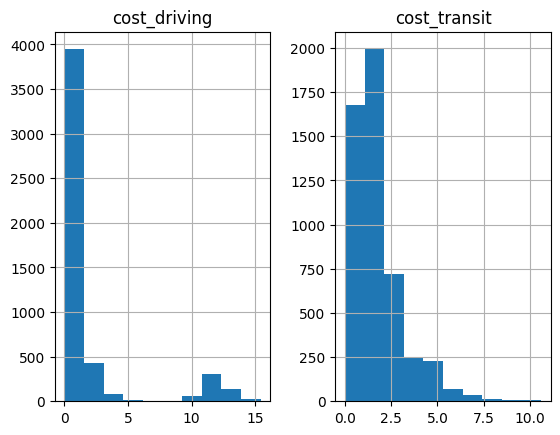

In [24]:
df[['cost_driving', 'cost_transit']].hist()

# Model Definition

In [3]:
# Assume every mode of transport is available
availability_walk = 1  
availability_cycle = 1  
availability_pt = 1     
availability_drive = 1

availability = {
    1: availability_walk,   # Walking
    2: availability_cycle,  # Cycling
    3: availability_pt,     # Public Transport
    4: availability_drive   # Driving
}

ASC_CYCLE = Beta('ASC_CYCLE', 0, None, None, 0)
ASC_PT = Beta('ASC_PT', 0, None, None, 0)
ASC_DRIVE = Beta('ASC_DRIVE', 0, None, None, 0)

# Define generic parameters for cost and travel time
B_COST = Beta('B_COST', 0, None, None, 0)

# Define interaction terms between ASCs and age_scaled
ASC_CYCLE_AGE = ASC_CYCLE + Beta('ASC_CYCLE_AGE', 0, None, None, 0) * age_scaled
ASC_PT_AGE = ASC_PT + Beta('ASC_PT_AGE', 0, None, None, 0) * age_scaled
ASC_DRIVE_AGE =  Beta('ASC_DRIVE_AGE', 0, None, None, 0) 
ASC_WALK_AGE =  Beta('ASC_WALK_AGE', 0, None, None, 0)

B_TIME_WALK = Beta('B_TIME_WALK', 0, None, None, 0)
B_TIME_CYCLE = Beta('B_TIME_CYCLE', 0, None, None, 0)
B_TIME_PT = Beta('B_TIME_PT', 0, None, None, 0)
B_TIME_DRIVE = Beta('B_TIME_DRIVE', 0, None, None, 0)

## BoxCox

In [4]:
LAMDA_COST = Beta('lambda_cost', 1, -10, 10, 0)
bx_cost_pt = boxcox(cost_transit, LAMDA_COST)
bx_cost_driving = boxcox(cost_driving, LAMDA_COST)

# Utility functions with interaction terms
V_WALK = ASC_WALK_AGE * age_scaled + B_TIME_WALK * dur_walking
V_CYCLE = ASC_CYCLE + B_TIME_CYCLE * dur_cycling
V_PT = ASC_PT + B_COST * bx_cost_pt + B_TIME_PT * dur_pt
V_DRIVE = (ASC_DRIVE + ASC_DRIVE_AGE * age_scaled) + B_COST * bx_cost_driving + B_TIME_DRIVE * dur_driving

# Associate utility functions with the mode choice
V = {
    1: V_WALK,    # Walking
    2: V_CYCLE,   # Cycling
    3: V_PT,      # Public Transport
    4: V_DRIVE    # Driving
}

# Specify the model
model_3_bx = loglogit({1: V_WALK, 2: V_CYCLE, 3: V_PT, 4: V_DRIVE}, availability, travel_mode)

### Results

In [5]:
biogeme_bx = bio.BIOGEME(database, model_3_bx)
biogeme_bx.modelName = 'model_3_bx'

results_m3_bx = biogeme_bx.estimate()

print("Estimation results for Model 3 Box Cox:")
print(results_m3_bx.get_estimated_parameters())

Estimation results for Model 3 Box Cox:
                  Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_CYCLE     -5.117298      0.247405   -20.683894      0.000000
ASC_DRIVE     -3.464264      0.238582   -14.520228      0.000000
ASC_DRIVE_AGE  0.540153      0.174325     3.098534      0.001945
ASC_PT        -3.164657      0.194648   -16.258332      0.000000
ASC_WALK_AGE  -0.895721      0.240877    -3.718578      0.000200
B_COST        -0.460634      0.052127    -8.836717      0.000000
B_TIME_CYCLE  -6.957434      0.511992   -13.588947      0.000000
B_TIME_DRIVE  -6.214024      0.377508   -16.460630      0.000000
B_TIME_PT     -3.765651      0.247736   -15.200248      0.000000
B_TIME_WALK   -9.541919      0.506065   -18.855118      0.000000
lambda_cost    0.323416      0.080978     3.993897      0.000065


In [6]:
print(results_m3_bx.print_general_statistics())

Number of estimated parameters:	11
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-6931.472
Final log likelihood:	-4204.073
Likelihood ratio test for the init. model:	5454.797
Rho-square for the init. model:	0.393
Rho-square-bar for the init. model:	0.392
Akaike Information Criterion:	8430.147
Bayesian Information Criterion:	8501.836
Final gradient norm:	2.8405E-02
Nbr of threads:	16



### Test against Model 2

In [7]:
folder_path = os.path.join(os.pardir, 'Model_2')
file_path = os.path.join(folder_path, 'Model_2A.pickle')

# open a file, where you stored the pickled data
file = open(file_path, 'rb')

# dump information to that file
results_m2 = pickle.load(file)

# close the file
file.close()

In [8]:
loglikehood_m3_bx = results_m3_bx.data.logLike
num_params_m3_bx = results_m3_bx.data.nparam

loglikehood_m2 = results_m2.logLike
num_params_m2 = results_m2.nparam

# Calculate the LR statistic
LR = 2 * (loglikehood_m3_bx - loglikehood_m2)

# Degrees of freedom
df = num_params_m3_bx - num_params_m2

# Critical value at 0.05 significance level
critical_value = chi2.ppf(0.95, df)

print("Likelihood Ratio:", LR)
print("Degrees of Freedom:", df)
print("Critical Chi-Square Value (0.05 significance):", critical_value)

if LR > critical_value:
    print("Model 3 Box Cox is significantly better than Model 2.")
else:
    print("No significant improvement in Model 3 Box Cox over Model 2.")

Likelihood Ratio: -2.7860561737143144
Degrees of Freedom: 1
Critical Chi-Square Value (0.05 significance): 3.841458820694124
No significant improvement in Model 3 Box Cox over Model 2.


## Power Series

In [9]:
square_tt_coef = Beta('square_cost_coef', 0, None, None, 0)
cube_tt_coef = Beta('cube_cost_coef', 0, None, None, 0)

def power_series(the_variable: Expression) -> Expression:
    """Generate the expression of a polynomial of degree 3

    :param the_variable: variable of the polynomial
    """
    return (
        the_variable
        + square_tt_coef * the_variable**2
        + cube_tt_coef * the_variable * the_variable**3
    )

In [10]:
power_cost_driving = power_series(cost_driving)
power_cost_pt = power_series(cost_transit)

# Utility functions with interaction terms
V_WALK = ASC_WALK_AGE * age_scaled + B_TIME_WALK * dur_walking
V_CYCLE = ASC_CYCLE + B_TIME_CYCLE * dur_cycling
V_PT = ASC_PT + B_COST * power_cost_pt + B_TIME_PT * dur_pt
V_DRIVE = (ASC_DRIVE + ASC_DRIVE_AGE * age_scaled) + B_COST * power_cost_driving + B_TIME_DRIVE * dur_driving



# Associate utility functions with the mode choice
V = {
    1: V_WALK,    # Walking
    2: V_CYCLE,   # Cycling
    3: V_PT,      # Public Transport
    4: V_DRIVE    # Driving
}

# Specify the model
model_3_power = loglogit({1: V_WALK, 2: V_CYCLE, 3: V_PT, 4: V_DRIVE}, availability, travel_mode)

### Results

In [11]:
biogeme_power = bio.BIOGEME(database, model_3_power)
biogeme_power.modelName = 'model_3_power'

results_m3_power = biogeme_power.estimate()

print("Estimation results for Model 3 Power:")
print(results_m3_power.get_estimated_parameters())

Estimation results for Model 3 Power:
                     Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_CYCLE        -4.979104      0.233262   -21.345556      0.000000
ASC_DRIVE        -2.749681      0.187653   -14.653023      0.000000
ASC_DRIVE_AGE     0.617577      0.172922     3.571411      0.000355
ASC_PT           -2.897621      0.188358   -15.383555      0.000000
ASC_WALK_AGE     -0.852614      0.235319    -3.623225      0.000291
B_COST           -0.294486      0.063408    -4.644303      0.000003
B_TIME_CYCLE     -6.936609      0.512695   -13.529703      0.000000
B_TIME_DRIVE     -6.931453      0.428816   -16.164165      0.000000
B_TIME_PT        -3.663302      0.250181   -14.642580      0.000000
B_TIME_WALK      -9.284384      0.469418   -19.778503      0.000000
cube_cost_coef   -0.000173      0.000289    -0.597640      0.550080
square_cost_coef -0.013033      0.047280    -0.275663      0.782807


In [12]:
print(results_m3_power.print_general_statistics())

Number of estimated parameters:	12
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4403.768
Final log likelihood:	-4194.328
Likelihood ratio test for the init. model:	418.8801
Rho-square for the init. model:	0.0476
Rho-square-bar for the init. model:	0.0448
Akaike Information Criterion:	8412.656
Bayesian Information Criterion:	8490.862
Final gradient norm:	1.7670E-02
Nbr of threads:	16



### Test Against Model 2

In [13]:
folder_path = os.path.join(os.pardir, 'Model_2')
file_path = os.path.join(folder_path, 'Model_2A.pickle')

# open a file, where you stored the pickled data
file = open(file_path, 'rb')

# dump information to that file
results_m2 = pickle.load(file)

# close the file
file.close()

In [14]:
loglikehood_m3_power = results_m3_power.data.logLike
num_params_m3_power = results_m3_power.data.nparam

loglikehood_m2 = results_m2.logLike
num_params_m2 = results_m2.nparam

# Calculate the LR statistic
LR = 2 * (loglikehood_m3_power - loglikehood_m2)

# Degrees of freedom
df = num_params_m3_power - num_params_m2

# Critical value at 0.05 significance level
critical_value = chi2.ppf(0.95, df)

print("Likelihood Ratio:", LR)
print("Degrees of Freedom:", df)
print("Critical Chi-Square Value (0.05 significance):", critical_value)

if LR > critical_value:
    print("Model 3 Power is significantly better than Model 2.")
else:
    print("No significant improvement in Model 3 Power over Model 2.")

Likelihood Ratio: 16.704513646107443
Degrees of Freedom: 2
Critical Chi-Square Value (0.05 significance): 5.991464547107979
Model 3 Power is significantly better than Model 2.


## Piecewise Linear

In [15]:
thresholds = [0, 1, 5, None]

beta_cost_0_5 = Beta('beta_cost_0_5', 0, None, None, 0)
beta_cost_5_10 = Beta('beta_cost_5_10', 0, None, None, 0)
beta_cost_10_more = Beta('beta_cost_10_more', 0, None, None, 0)
betas_piecewise = [beta_cost_0_5, 
                   beta_cost_5_10, 
                   beta_cost_10_more]

piecewise_cost_driving = piecewise_formula(
    'cost_driving', thresholds, betas_piecewise
)

piecewise_cost_pt = piecewise_formula(
    'cost_transit', thresholds, betas_piecewise
)


In [16]:
# Utility functions with interaction terms
V_WALK = ASC_WALK_AGE * age_scaled + B_TIME_WALK * dur_walking
V_CYCLE = ASC_CYCLE + B_TIME_CYCLE * dur_cycling
V_PT = ASC_PT + B_COST * piecewise_cost_pt + B_TIME_PT * dur_pt
V_DRIVE = (ASC_DRIVE + ASC_DRIVE_AGE * age_scaled) + B_COST * piecewise_cost_driving + B_TIME_DRIVE * dur_driving

# Associate utility functions with the mode choice
V = {
    1: V_WALK,    # Walking
    2: V_CYCLE,   # Cycling
    3: V_PT,      # Public Transport
    4: V_DRIVE    # Driving
}

# Specify the model
model_3_piecewise = loglogit({1: V_WALK, 2: V_CYCLE, 3: V_PT, 4: V_DRIVE}, availability, travel_mode)

### Results

In [17]:
biogeme_piecewise = bio.BIOGEME(database, model_3_piecewise)
biogeme_piecewise.modelName = 'model_3_piecewise'

results_m3_piecewise = biogeme_piecewise.estimate()

print("Estimation results for Model 3 piecewise:")
print(results_m3_piecewise.get_estimated_parameters())

Estimation results for Model 3 piecewise:
                      Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_CYCLE         -5.055934      0.238862   -21.166726      0.000000
ASC_DRIVE         -2.722347      0.187677   -14.505453      0.000000
ASC_DRIVE_AGE      0.676125      0.170998     3.953986      0.000077
ASC_PT            -2.776682      0.187073   -14.842782      0.000000
ASC_WALK_AGE      -0.810659      0.235190    -3.446833      0.000567
B_COST            -1.269533      0.587358    -2.161428      0.030662
B_TIME_CYCLE      -6.814750      0.524493   -12.993027      0.000000
B_TIME_DRIVE      -6.515886      0.374910   -17.379865      0.000000
B_TIME_PT         -3.839686      0.253135   -15.168520      0.000000
B_TIME_WALK       -9.417830      0.473823   -19.876261      0.000000
beta_cost_0_5      0.534561      0.286760     1.864139      0.062302
beta_cost_10_more  0.157629      0.095175     1.656208      0.097680
beta_cost_5_10     0.036817      0.024773     1.486191      0

In [18]:
print(results_m3_piecewise.print_general_statistics())

Number of estimated parameters:	13
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4309.741
Final log likelihood:	-4183.745
Likelihood ratio test for the init. model:	251.9933
Rho-square for the init. model:	0.0292
Rho-square-bar for the init. model:	0.0262
Akaike Information Criterion:	8393.49
Bayesian Information Criterion:	8478.213
Final gradient norm:	1.8998E-02
Nbr of threads:	16



### Test Against Model 2

In [19]:
folder_path = os.path.join(os.pardir, 'Model_2')
file_path = os.path.join(folder_path, 'Model_2B.pickle')

# open a file, where you stored the pickled data
file = open(file_path, 'rb')

# dump information to that file
results_m2 = pickle.load(file)

# close the file
file.close()

In [20]:
loglikehood_m3_piecewise = results_m3_piecewise.data.logLike
num_params_m3_piecewise = results_m3_piecewise.data.nparam

loglikehood_m2 = results_m2.logLike
num_params_m2 = results_m2.nparam

# Calculate the LR statistic
LR = 2 * (loglikehood_m3_piecewise - loglikehood_m2)

# Degrees of freedom
df = num_params_m3_piecewise - num_params_m2

# Critical value at 0.05 significance level
critical_value = chi2.ppf(0.95, df)

print("Likelihood Ratio:", LR)
print("Degrees of Freedom:", df)
print("Critical Chi-Square Value (0.05 significance):", critical_value)

if LR > critical_value:
    print("Model 3 piecewise is significantly better than Model 2.")
else:
    print("No significant improvement in Model 3 piecewise over Model 2.")

Likelihood Ratio: 21.191534769852296
Degrees of Freedom: 2
Critical Chi-Square Value (0.05 significance): 5.991464547107979
Model 3 piecewise is significantly better than Model 2.
